# output verification

Date: 18 May, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is on the order of 50TB of float data over nearly 9000 `netcdf` file assests in total.

#### required packages

In [2]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from dask.distributed import Client, LocalCluster
import dask
import datetime
import zarr

from rechunker import rechunk

import gc
import sys
import subprocess
from tabulate import tabulate
import os
import glob
import streamjoy
import pickle

In [47]:
!pip install brokenaxes

In [3]:
# Append the directory of the module to sys.path - import functions
sys.path.append('/g/data/es60/users/thomas_moore/code/Climatology-generator-demo/src/')
import bran2020_demo_functions as my_tools
from bran2020_demo_functions import keep_only_selected_vars, load_rechunker_config, print_chunks, rechunk_each_st_ocean, remove_zarr_encoding, version_table, concatinate_st_ocean_zarrs

In [3]:
version_table()

+-----------+-----------+------------+-----------+
| Package   | Version   | Package    | Version   |
+===========+===========+============+===========+
| numpy     | 1.26.4    | numba      | 0.59.1    |
+-----------+-----------+------------+-----------+
| xarray    | 2024.3.0  | numbagg    | 0.8.1     |
+-----------+-----------+------------+-----------+
| dask      | 2024.4.0  | flox       | 0.9.6     |
+-----------+-----------+------------+-----------+
| scipy     | 1.12.0    | bottleneck | 1.3.8     |
+-----------+-----------+------------+-----------+


#### start a local Dask client

In [4]:
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

cluster = LocalCluster(
    n_workers=14,          # Number of workers
    threads_per_worker=1#,
    #memory_limit='8GB' # Memory limit per each worker
)
client = Client(cluster)

In [5]:
# Create an empty dictionary
dynamic_ds = {}

# Define your var and phase lists
var_values = ['temp', 'salt','u','v','eta_t','mld']  # replace with your actual list
phase_values = ['alltime', 'neutral','la_nina','el_nino']  # replace with your actual list

# Iterate over all combinations of var and phase
for var_name in var_values:
    for phase_name in phase_values:
        # Generate the object name
        ds_name = f'{var_name}_{phase_name}_ds'
        
        # Store the value in the dictionary
        results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_intermediate_results/'
        files = glob.glob(results_path+'*'+var_name+'*'+phase_name+'*.nc')
        sorted_files = sorted(files, key=os.path.getctime)
        
        dynamic_ds[ds_name] = xr.open_mfdataset(files,parallel=True)  # replace with your actual value

In [6]:
# Add the phase string to the name of all variables in each dataset
for ds_name, dataset in dynamic_ds.items():
    # Get the phase name from the dataset name
    phase_name = '_'.join(ds_name.split('_')[1:-1])
    if phase_name not in phase_values:
        phase_name = '_'.join(ds_name.split('_')[2:-1])
    if phase_name in phase_values:
        # Add the phase string to the name of all variables
        for var_name in dataset.data_vars:
            new_var_name = f'{var_name}_{phase_name}'
            dataset = dataset.rename({var_name: new_var_name})
        dynamic_ds[ds_name] = dataset
    else:
        print(f"No match found for phase name: {phase_name}")

In [7]:
merged_datasets = {}
for var_name in var_values:
        # Get all datasets with the same var_name
        var_datasets = [dataset for ds_name, dataset in dynamic_ds.items() if var_name in ds_name]
        
        # Merge the datasets along the time dimension
        merged_dataset = xr.merge(var_datasets)
        
        # Store the merged dataset in the dictionary
        merged_datasets[var_name] = merged_dataset

In [8]:
# Calculate the total size of all datasets in the dictionary
total_size_gb = sum(merged_dataset.nbytes / (1024**3) for merged_dataset in merged_datasets.values())
print(f"Total size of all datasets: {total_size_gb} GB")

Total size of all datasets: 1991.0576639771461 GB


##### `/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_intermediate_results du -hsc *.nc` = 532G	total

In [9]:
# Show the keys for the dynamic_ds dictionary
print(merged_datasets.keys())

dict_keys(['temp', 'salt', 'u', 'v', 'eta_t', 'mld'])


# use a pickled dict to load ALL the data

In [10]:
# Lazy load each dataset
lazy_datasets = {}
for var_name, merged_dataset in merged_datasets.items():
    #print([var_name,merged_dataset])
    lazy_datasets[var_name] = merged_dataset

lazy_datasets.keys()



dict_keys(['temp', 'salt', 'u', 'v', 'eta_t', 'mld'])

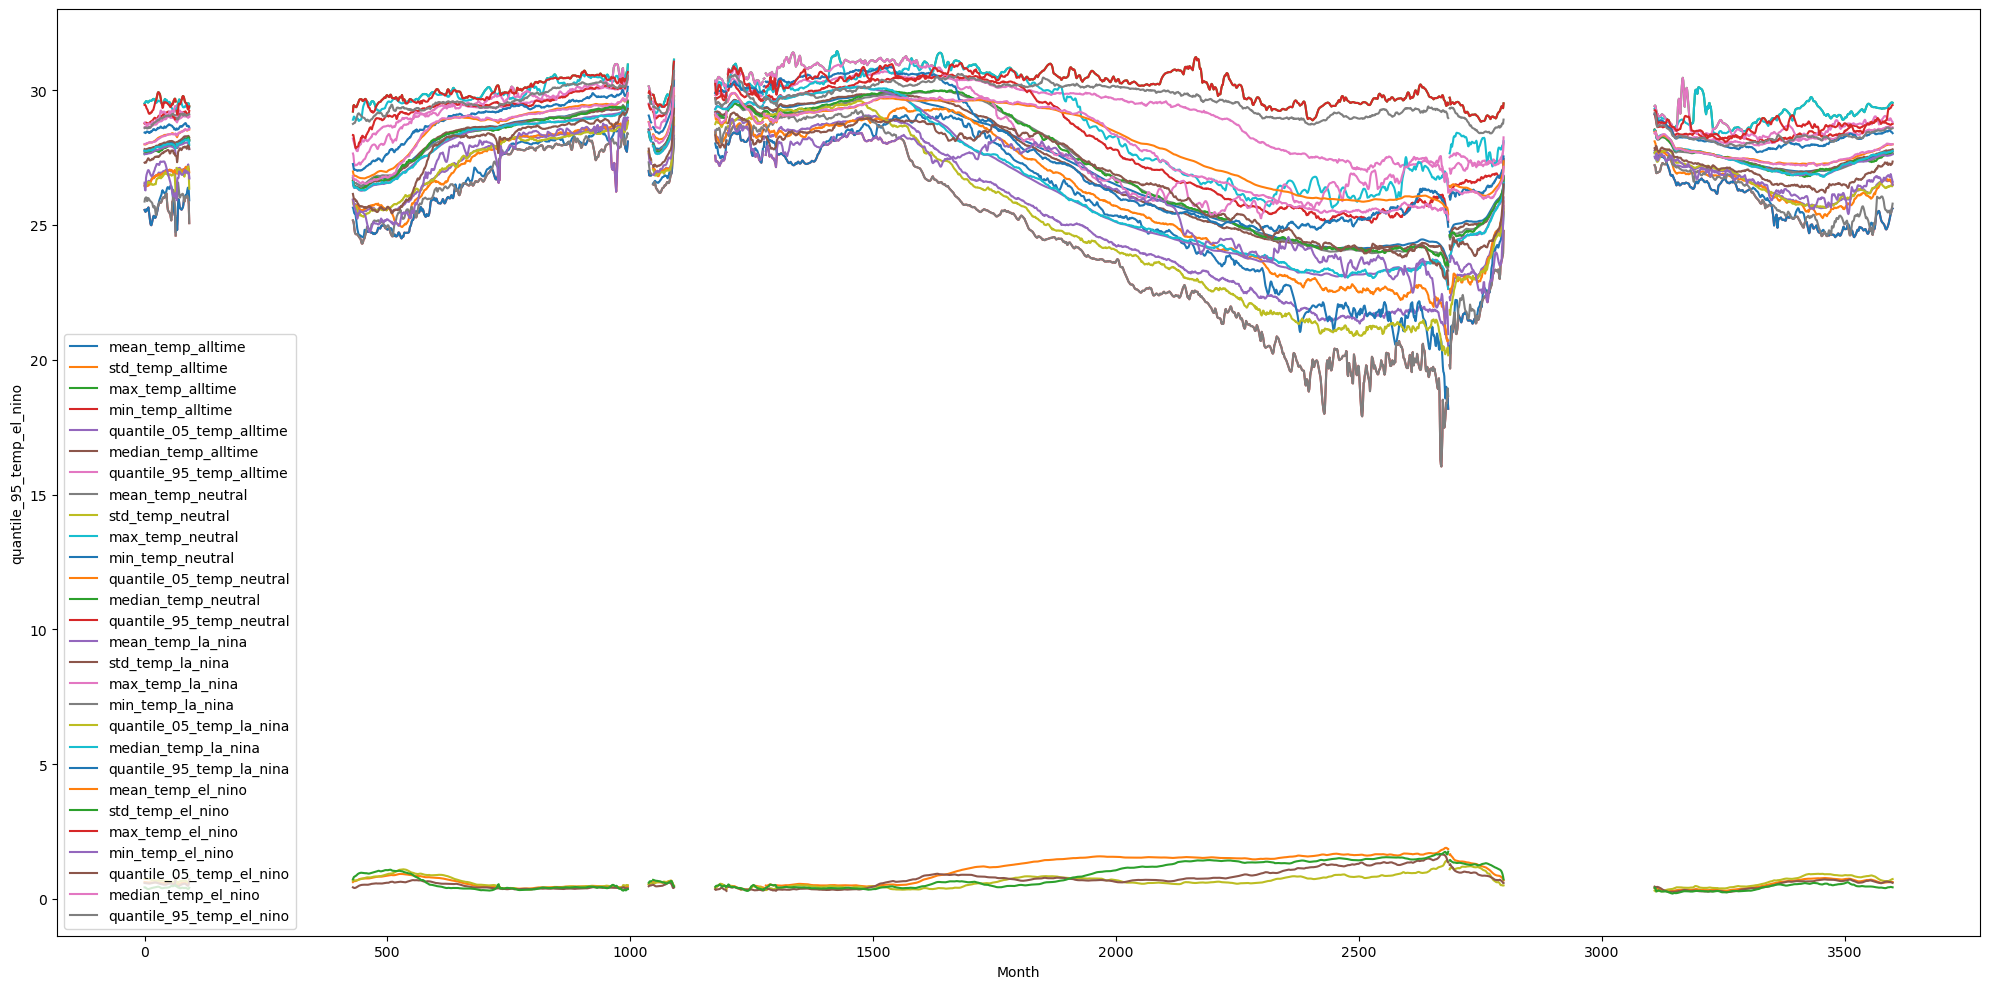

In [24]:
# Access the variables in each lazy-loaded dataset
var_name = 'temp'
sel_dict = {'st_ocean': 0, 'yt_ocean': 0,'month':1}
lazy_dataset = lazy_datasets[var_name]

# Create a 4x7 subplot grid
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
for plot_var in lazy_dataset.data_vars:
    # Plot the timeseries for the current variable
    plt.plot(lazy_dataset[plot_var].sel(sel_dict,method="nearest"), label=plot_var)
    # Add labels and legend to the plot
    plt.xlabel('Month')
    plt.ylabel(plot_var)
    plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

# plotting

## define phase and core variable names

In [17]:
phase_list=['alltime','la_nina','el_nino','neutral']
core_var_list=['temp','salt','u','v','mld','eta_t']

## Define a dictionary to map variable names to colors and styles

In [18]:
# Define a dictionary to map variable names to colors and styles
base_color_dict = {
    'mean': 'black',
    'min': 'navy',
    'max': 'red',
    'std': 'lightgrey',
    'median':'darkgrey',
    'quantile_05':'lightblue' ,
    'quantile_95': 'orange'
}
base_style_dict = {
    'alltime':'solid',
    'neutral':'dashdot',
    'la_nina':'dotted',
    'el_nino':'dashed'
}

In [25]:
core_var = core_var_list[0]
ds = lazy_datasets[core_var]

In [54]:
ds.sel(sel_dict,method='nearest').nbytes/(1024**3)

0.0004023537039756775

In [26]:
variables = list(ds.data_vars)

### code to run per dataset to generate the colours and phase styles

In [36]:
color_dict={}
style_dict={}
for var_name in variables:
    # Get the first part of the variable name
    var_prefix = var_name.split('_')[0]
    
    # Check if the var_prefix exists in color_dict
    if var_prefix in base_color_dict:
        # Get the corresponding color from color_dict
        color_dict[var_name] = base_color_dict[var_prefix]
        
        # Use the color for further processing or visualization
        # . . .
        
    else:
        var_prefix = '_'.join(var_name.split('_')[:2])
        if var_prefix in base_color_dict:
            # Get the corresponding color from color_dict
            color_dict[var_name] = base_color_dict[var_prefix]
        
            # Use the color for further processing or visualization
            # ...
        else:
            print(f"No color defined for variable prefix: {var_prefix}")
for var_name in variables:
    # Get the first part of the variable name
    var_prefix = var_name.split('_')[-1]
    
    # Check if the var_prefix exists in color_dict
    if var_prefix in base_style_dict:
        # Get the corresponding color from color_dict
        style_dict[var_name] = base_style_dict[var_prefix]
        
        # Use the style for further processing or visualization
        # . . .
        
    else:
        var_prefix = '_'.join(var_name.split('_')[-2:])
        if var_prefix in base_style_dict:
            # Get the corresponding color from color_dict
            style_dict[var_name] = base_style_dict[var_prefix]
        
            # Use the style for further processing or visualization
            # ...
        else:
            print(f"No style defined for variable prefix: {var_prefix}")

## coordinate nomeclature

In [37]:
coordinate_names = {"lat_name_dict": {
        "temp": "yt_ocean",
        "salt": "yt_ocean",
        "u": "yu_ocean",
        "v": "yu_ocean",
        "mld": "yt_ocean",
        "eta_t": "yt_ocean"
    },
    "lon_name_dict": {
        "temp": "xt_ocean",
        "salt": "xt_ocean",
        "u": "xu_ocean",
        "v": "xu_ocean",
        "mld": "xt_ocean",
        "eta_t": "xt_ocean"
    }
                   }

# equator @ surface

In [55]:
eq = ds.sel(sel_dict,method='nearest').compute()

In [39]:
depth_sel_dict = {'st_ocean':0}
lon_sel_dict = {coordinate_names["lat_name_dict"][core_var]:0}
month_sel_dict = {'month':3}
sel_dict = {**depth_sel_dict, **lon_sel_dict, **month_sel_dict}

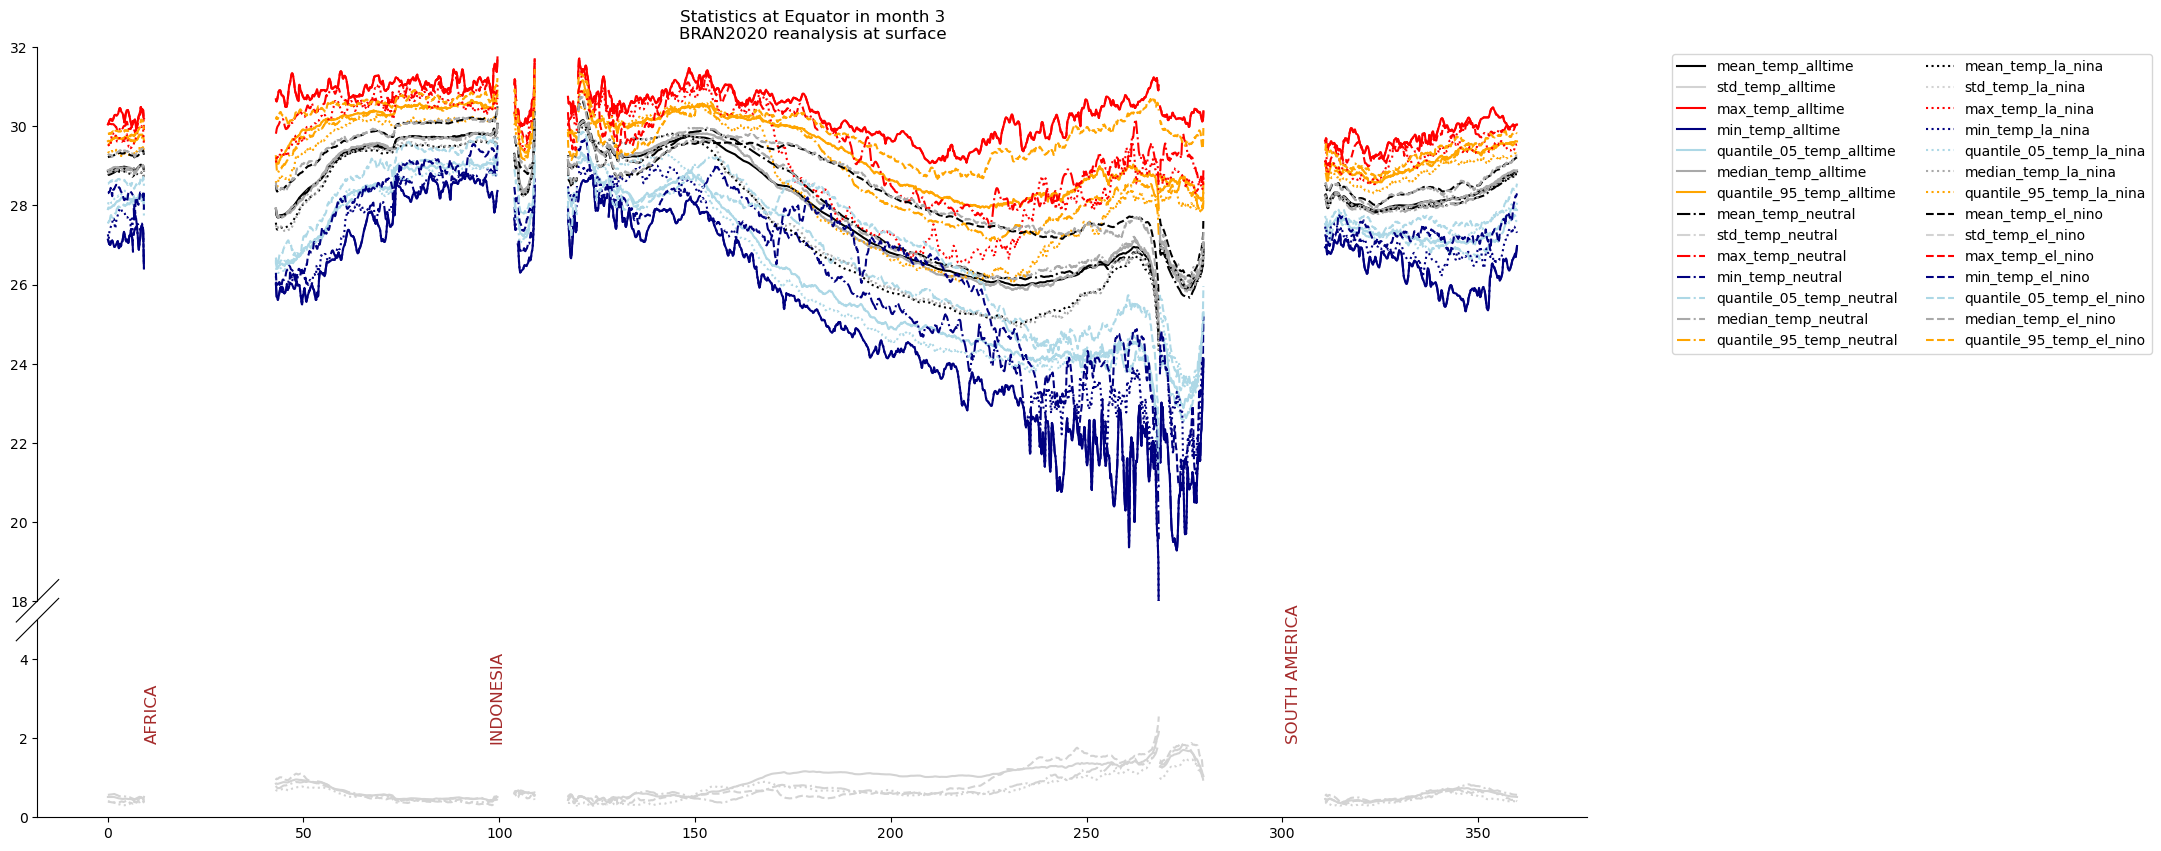

In [69]:
from brokenaxes import brokenaxes
#plot
# Get the list of variables in the dataset
variables = list(ds.data_vars)

# Plot line for each variable
fig = plt.figure(figsize=(20, 10))  # Set the figure size here
bax = brokenaxes(ylims=((0, 5), (18, 32)), hspace=.05)
for variable in variables:
    color = color_dict.get(variable, 'black')  # Use 'black' as default color if variable is not in the dictionary
    style = style_dict.get(variable, 'solid')
    #bax.plot(ds[variable].sel(sel_dict,method='nearest'),color=color, linestyle=style)
    bax.plot(eq[coordinate_names["lon_name_dict"][core_var]].values,eq[variable].values,color=color, linestyle=style, label=variable)
    # Add text to a specific location

y_location = 0.1    
bax.big_ax.text((25/360), y_location, 'AFRICA', fontsize=12, color='brown', rotation=90)
bax.big_ax.text((105/360), y_location, 'INDONESIA', fontsize=12, color='brown', rotation=90)
bax.big_ax.text((290/360), y_location, 'SOUTH AMERICA', fontsize=12, color='brown', rotation=90)
# Add title
plt.title('Statistics at Equator in month '+str(month_sel_dict['month'])+'\nBRAN2020 reanalysis at surface')
#legend
# Add legend with two columns
bax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.show()


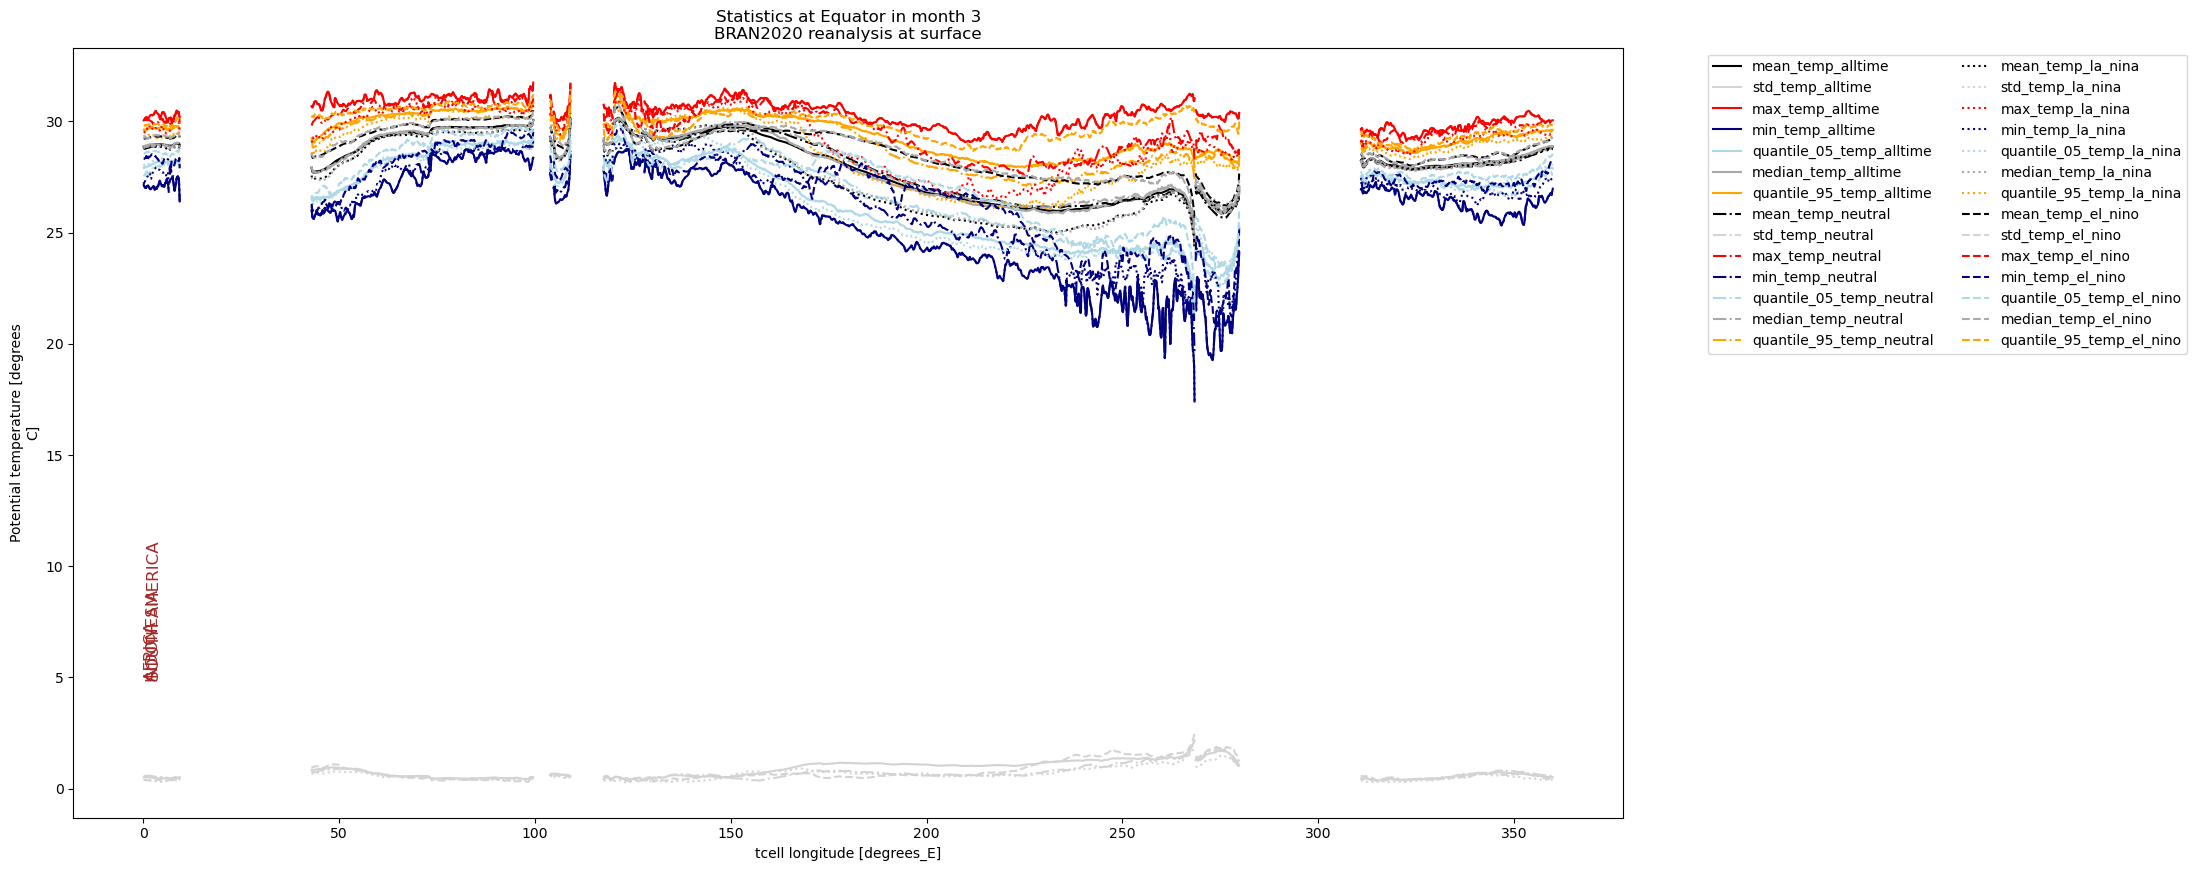

In [63]:
#plot
# Get the list of variables in the dataset
variables = list(ds.data_vars)

# Plot line for each variable
fig, ax = plt.subplots(figsize=(20, 10))  # Set the figure size here
for variable in variables:
    color = color_dict.get(variable, 'black')  # Use 'black' as default color if variable is not in the dictionary
    style = style_dict.get(variable, 'solid')
    ds[variable].sel(sel_dict,method='nearest').plot.line(x=coordinate_names["lon_name_dict"][core_var], 
                                                         label=variable, color=color, linestyle=style, ax=ax)

# Add text to a specific location
y_location = 5
#y_location = -3.5
plt.text(25, y_location, 'AFRICA', fontsize=12, color='brown', rotation=90)
plt.text(105, y_location, 'INDONESIA', fontsize=12, color='brown', rotation=90)
plt.text(290, y_location, 'SOUTH AMERICA', fontsize=12, color='brown', rotation=90)

# Add legend with two columns
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

# Add title
plt.title('Statistics at Equator in month '+str(month_sel_dict['month'])+'\nBRAN2020 reanalysis at surface')
# Set the background color to black
#plt.gca().set_facecolor('lightgrey')

# Save the plot as PNG
#plt.savefig(plot_directory+'Temp-Statistics-at-Equator-surface-in-March.png', dpi=300,bbox_inches='tight')
# Show the plot
plt.show()


TypeError: can only concatenate str (not "int") to str

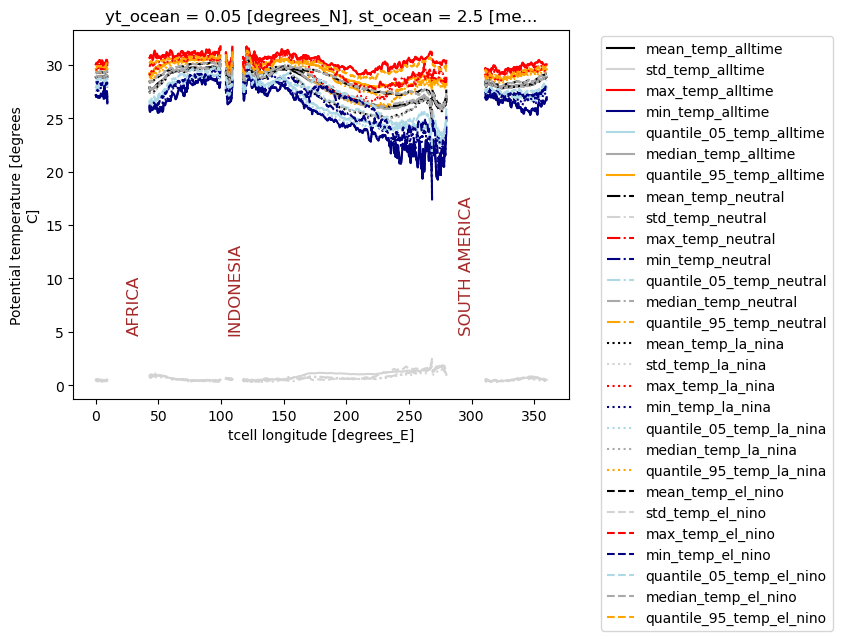

In [43]:
# Get the list of variables in the dataset
variables = list(ds.data_vars)

# Plot line for each variable
for variable in variables:
    color = color_dict.get(variable, 'black')  # Use 'black' as default color if variable is not in the dictionary
    style = style_dict.get(variable, 'solid')
    ds[variable].sel(sel_dict,method='nearest').plot.line(x=coordinate_names["lon_name_dict"][core_var], 
                                                                                    label=variable, color=color,linestyle=style)

# Add text to a specific location
y_location = 5
#y_location = -3.5
plt.text(25, y_location, 'AFRICA', fontsize=12, color='brown', rotation=90)
plt.text(105, y_location, 'INDONESIA', fontsize=12, color='brown', rotation=90)
plt.text(290, y_location, 'SOUTH AMERICA', fontsize=12, color='brown', rotation=90)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Add title
plt.title('Statistics at Equator in '+str(month_sel_dict['month'])+'\nBRAN2020 reanalysis at surface')
# Set the background color to black
#plt.gca().set_facecolor('lightgrey')

# Save the plot as PNG
#plt.savefig(plot_directory+'Temp-Statistics-at-Equator-surface-in-March.png', dpi=300,bbox_inches='tight')
# Show the plot
plt.show()


In [ ]:
lazy_datasets['temp'].nbytes/(1024**3)

# what is the chunking?

In [ ]:
mld = lazy_datasets['temp']
mld

In [ ]:
mld_tiny_chunk = mld.chunk({'month':1,'xt_ocean':300,'yt_ocean':300})
mld_tiny_chunk

In [ ]:
%%time
mld_tiny_chunk = mld_tiny_chunk.compute()

In [ ]:
mld_tiny_chunk

In [ ]:
%%time
encoding = {} #setup encoding dict
chunksizes_tuple = (1, 300, 300) #set chunksizes for netcdf write
for var_name in mld_tiny_chunk.data_vars:
    encoding[var_name] = {'zlib': True, 'complevel': 5, 'dtype': 'float32', 'chunksizes': chunksizes_tuple} # encode only the data variables
# Save to NetCDF with chunking and compression encoding
mld_tiny_chunk.to_netcdf('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_final_results/mld_01300300.nc',
                         engine='netcdf4',encoding=encoding)

In [ ]:
check_mld = xr.open_mfdataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_final_results/mld_01300300.nc',chunks={})
check_mld

In [ ]:
lazy_datasets['temp']

In [ ]:
data = (lazy_datasets['temp']).std_temp_alltime

In [ ]:
data

In [ ]:
data.chunk({'month':1,'st_ocean':1,'xt_ocean':300,'yt_ocean':300})

# checking on length of period for existing `mld` & `eta_t` `zarr` collections

In [ ]:
eta_t_collection = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/BRAN2020-daily-eta_t-chunk4time-v14032024.zarr'
eta_t = xr.open_zarr(eta_t_collection,consolidated=True)
eta_t

In [ ]:
mld_collection = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/BRAN2020-daily-mld-chunk4month_clim-22042023.zarr'
zarr.consolidate_metadata(mld_collection)

In [ ]:
mld_collection = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/BRAN2020-daily-mld-v04042024.zarr'
mld = xr.open_zarr(mld_collection,consolidated=True)
mld

# inspecting the draft results

In [ ]:
var='v'
results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_intermediate_results/'
files = glob.glob(results_path+'*'+var+'*'+'el_nino*.nc')
sorted_files = sorted(files, key=os.path.getctime)
sorted_files_neutral = sorted_files
sorted_files_neutral

In [ ]:
files = glob.glob(results_path+'*'+var+'*'+'la_nina*.nc')
sorted_files = sorted(files, key=os.path.getctime)
sorted_files_lanina = sorted_files
sorted_files_lanina

In [ ]:
el_nino_files = sorted_files_neutral
la_nina_files = sorted_files_lanina

In [ ]:
ds_el_nino = xr.open_mfdataset(el_nino_files,parallel=True)
ds_la_nina = xr.open_mfdataset(la_nina_files,parallel=True)

In [ ]:
diff = ds_el_nino - ds_la_nina

In [ ]:
diff

In [ ]:
if var == 'mld' or var == 'eta_t':
    surface_monthslice = diff.isel({'month':0})
else:
    surface_monthslice = diff.isel({'month':0,'st_ocean':0})
surface_monthslice = surface_monthslice.compute()

In [ ]:
data = surface_monthslice

import math
# Get the number of variables in the dataset
num_vars = len(data.data_vars)

# Determine the grid size (e.g., square root of the number of variables)
ncols = int(math.ceil(math.sqrt(num_vars)))
nrows = int(math.ceil(num_vars / ncols))

# Define the aspect ratio for each subplot (width / height)
aspect_ratio = 1.5  # For example, 1.5 means width is 1.5 times the height

# Calculate figure size
fig_width = 5 * ncols  # Width of the figure
fig_height = fig_width / aspect_ratio  # Height of the figure, maintaining the aspect ratio

# Create a figure and subplots with the specified aspect ratio
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable in a separate subplot
for ax, (var_name, var_data) in zip(axes, data.data_vars.items()):
    var_data.plot(ax=ax)
    ax.set_title(var_name)

# Remove any empty subplots
for ax in axes[num_vars:]:
    fig.delaxes(ax)

# Adjust layout
fig.suptitle('BRAN2020 '+var+' - January - surface\nENSO El Nino - La Nina') 
plt.tight_layout()
plt.show()

In [ ]:
stats_dataset = ds_all

In [ ]:
stats_dataset.nbytes/1e9

# load all BRAN salt

In [ ]:
var='salt'

In [ ]:
xarray_open_kwargs = {"Time": 1, "st_ocean": 51, "xt_ocean": 3600, "yt_ocean": 1500}
#
vars_to_keep=[var,'Time','st_ocean','yt_ocean','xt_ocean']
bran_salt = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/daily/ocean_'+var+'_*.nc',
                    parallel=True,chunks=xarray_open_kwargs,
                    preprocess=lambda ds: keep_only_selected_vars(ds, vars_to_keep=vars_to_keep))
bran_salt

In [ ]:
SSS = bran_salt.isel(st_ocean=0)
SSS_SouthAM_eq = SSS.sel({'yt_ocean':slice(-8,15),'xt_ocean':slice(305,327)})
SSS_SouthAM_eq

In [ ]:
SSS_SouthAM_eq_rc = SSS_SouthAM_eq.chunk({'Time':1200})
SSS_SouthAM_eq_rc                           

In [ ]:
%%time
SSS_SouthAM_eq_rc = SSS_SouthAM_eq_rc.compute()

# plots

In [ ]:
min_all_time = SSS_SouthAM_eq_rc.min(dim='Time',skipna=False)
min_all_time.salt.plot()
plt.title('Min Salt over all time')
plt.show()


In [ ]:
max_all_time = SSS_SouthAM_eq_rc.max(dim='Time',skipna=False)
max_all_time.salt.plot()
plt.title('Max Salt over all time')
plt.show()

In [ ]:
import streamjoy.xarray
SSS_SouthAM_eq_rc.streamjoy(uri="/scratch/es60/thomas_moore/streamjoy_out/SSS_SouthAM_eq_alltime_noflicker.mp4",
                            max_frames=-1,
                            scratch_dir="/scratch/es60/thomas_moore/streamjoy_scratch",
                            client = client,
                            threads_per_worker=1
                           )

In [ ]:
diff = (ds.median_temp - ds.mean_temp)
diff

In [ ]:
diff.isel({'month':0,'st_ocean':0}).plot()
plt.title('median - mean temp')

# Show the plot
plt.show()

### try recompressing

In [ ]:
def compress_nc(ds,out_path,compression_level=4):
    compression_opts = {
        'zlib': True,        # Enable zlib compression
        'complevel': compression_level,      # Compression level (1-9)
    }

    # Set the encoding for each variable
    encoding = {var: compression_opts for var in ds.data_vars}

    # Write the dataset to a new NetCDF file with compression
    ds.to_netcdf(out_path, encoding=encoding)

In [ ]:
%%time
compress_nc(mld_stats_dataset,'/g/data/es60/users/thomas_moore/clim_demo_results/daily/draft_delivery/why_so_big/out.nc',compression_level=1)

In [ ]:
out_data = xr.open_dataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/draft_delivery/why_so_big/out.nc',chunks={})
out_data

In [ ]:
out_data.nbytes/1e9

In [ ]:
max_mld = mld_stats_dataset[['max_mld','max_el_nino_mld','max_la_nina_mld']]
max_mld

In [ ]:
sel_dict = {'month':0}

In [ ]:
data = max_mld.sel(sel_dict,method='nearest')
data

In [ ]:
diff = data.max_la_nina_mld - data.max_mld
diff

In [ ]:
diff.min().values

In [ ]:
diff.plot()

# where are the zarr collections:

In [ ]:
zarr_path = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/'
temp_chunk4time_zarr = 'BRAN2020-daily-temp-chunk4time-v07022024.zarr'

In [ ]:
temp_chunk4time = xr.open_zarr(zarr_path+temp_chunk4time_zarr,consolidated=True)

In [ ]:
temp_chunk4time

In [ ]:
%%time
equator_over_time = temp_chunk4time.temp.sel({'yt_ocean':0},method='nearest')

In [ ]:
%%time
equator_over_time = equator_over_time.compute()

In [ ]:
equator_over_time.streamjoy('/g/data/es60/users/thomas_moore/clim_demo_results/plots/equator_temp.mp4',max_frames=-1,dim='Time')

In [ ]:
_slice_.plot()

In [ ]:
%time
result = result.compute()

In [ ]:
result.plot()

# ARD workflow

### read paths from config file

#### [ you will need to specifiy your correct path for the `data-catalogue/config.ini` file ]

In [ ]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config file
#########
#### you will need to specifiy your correct path the the `data-catalogue/config.ini` file 
#########
config.read('./code/BRAN2020-intake-catalog/config.ini')

# Get the value of a variable
catalog_path = config.get('paths', 'catalog_path')

In [ ]:
catalog_path

In [ ]:
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json',columns_with_iterables=['variable'])

In [ ]:
BRAN2020_catalog

In [ ]:
BRAN2020_catalog.unique()['source']

In [ ]:
BRAN2020_catalog.unique()['domain']

In [ ]:
BRAN2020_catalog.unique()['time_period']

In [ ]:
var_list = BRAN2020_catalog.unique()['variable']
var_list.sort()
df = pd.DataFrame(var_list, columns=['BRAN2020 Variables'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

In [ ]:
search = BRAN2020_catalog.search(variable=['mld'],time_period=['daily'])

In [ ]:
search.unique()['variable']

In [ ]:
search

In [ ]:
search.df

### Out of some 9000 files we now have narrowed down the just the 366 that have the information we need

#### We can now load all that data into a single 240GB "lazy" `xarray` object for further reduction and analysis

In [ ]:
%%time
xarray_open_kwargs = {"chunks": {"time": 1, "xt_ocean": 3600, "yt_ocean": 1500}}
DS=search.to_dask(xarray_open_kwargs=xarray_open_kwargs)

In [ ]:
DS

In [ ]:
DS.nbytes/1e9

## ARD - write zarr & chunk & write zarr

In [ ]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/'
ard_file_ID = 'BRAN2020-daily-mld-v04042024.zarr'

In [ ]:
%%time
DS.to_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)
# ----- Client(threads_per_worker=1) -------
# CPU times: user 2min 26s, sys: 29.9 s, total: 2min 56s
# Wall time: 13min 1s
# ----- Client() -------
# CPU times: user 1min 53s, sys: 18.1 s, total: 2min 11s
# Wall time: 14min 3s

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/finished_BRAN2020-mld-base-zarr.log

## RELOAD in ARD collection

In [ ]:
BRAN2020_daily_var = xr.open_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)

In [ ]:
BRAN2020_daily_var

## CHUNK for time and WRITE zarr

### "Consider either rechunking using `chunk()`, deleting or modifying `encoding['chunks']`"

In [ ]:
def remove_zarr_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

In [ ]:
ard_rcTime_file_ID = 'BRAN2020-daily-mld-chunk4time-v04042024.zarr'

In [ ]:
BRAN2020_daily_var_rcTime =  BRAN2020_daily_var.chunk({'Time':-1,'xt_ocean':9,'yt_ocean':1500})
BRAN2020_daily_var_rcTime

In [ ]:
BRAN2020_daily_var_rcTime = remove_zarr_encoding(BRAN2020_daily_var_rcTime)

In [ ]:
%%time
BRAN2020_daily_var_rcTime.to_zarr(BRAN2020_ard_path+ard_rcTime_file_ID,consolidated=True)

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/finished_BRAN2020-mld-rechunk-zarr.log

# rechunker approach

In [ ]:
input_ds = BRAN2020_daily_var
target_chunks = {'Time':-1,'xt_ocean':9,'yt_ocean':1500}
max_mem = "2GB"

target_store = BRAN2020_ard_path+ard_rcTime_file_ID
temp_store = "/scratch/es60/ard/rechunker_scratch/rechunker-tmp.zarr"

# need to remove the existing stores or it won't work
!rm -rf /scratch/es60/ard/rechunker_scratch/rechunker-tmp.zarr

# rechunk directly from dataset this time
rechunk_plan = rechunk(
    input_ds, target_chunks, max_mem, target_store, temp_store=temp_store
)
rechunk_plan

In [ ]:
%%time
rechunk_plan.execute()

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/finished_BRAN2020-mld-rechunker-zarr.log

In [ ]:
zarr.consolidate_metadata(target_store)

## end ARD workflow $\Uparrow$

# begin post-processing workflow $\Downarrow$

## load in zarr collection

In [ ]:
var_chunked_time = xr.open_zarr(BRAN2020_ard_path + ard_rcTime_file_ID,consolidated=True)
var_chunked_time

## basic functions

In [ ]:
def get_bran_monthly_climatologies(xr_object,time_coord_name = 'Time'):
    monthly_climatologies = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True,method="cohorts", engine="flox")
    result = data.groupby('time').temperature.agg(['mean', 'sum'])
    
return result



# Climatology

In [ ]:
temp_monthly_climatology = get_monthly_climatology(temp_chunked_time, time_coord_name = 'Time')
temp_monthly_climatology

In [ ]:
temp_monthly_climatology_rc = temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})

In [ ]:
%%time
temp_monthly_climatology = temp_monthly_climatology.compute()

# CPU times: user 32.1 s, sys: 17.9 s, total: 49.9 s
# Wall time: 2min 20s
#

# Anomaly

In [ ]:
temp_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology_rc,time_coord_name='Time')

In [ ]:
temp_anomaly

# define El Nino and La Nina using NCAR ONI data

In [ ]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')
ONI_DF.set_index('datetime',inplace=True)
ONI_DF.index = pd.to_datetime(ONI_DF.index)
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_threshold_months = ONI_DF["ONI"].ge(el_nino_threshold)
la_nina_threshold_months = ONI_DF["ONI"].le(la_nina_threshold) 
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.rename('El Nino threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.rename('La Nina threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.diff().ne(0).cumsum().rename('El Nino event group ID')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.diff().ne(0).cumsum().rename('La Nina event group ID')], axis=1)

In [ ]:
El_Nino_Series = ONI_DF.groupby('El Nino event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['El Nino threshold'] == True)
ONI_DF = pd.concat([ONI_DF, El_Nino_Series.rename('El Nino')], axis=1)
La_Nina_Series = ONI_DF.groupby('La Nina event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['La Nina threshold'] == True)
ONI_DF = pd.concat([ONI_DF, La_Nina_Series.rename('La Nina')], axis=1)
ONI_DF

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['El Nino'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI El Nino events') 
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['La Nina'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI La Nina events') 
plt.show()

## heatmap

### make table for average over certain region

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = temp_anomaly.temp.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'Time':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_of_ONI_anomaly = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_of_ONI_anomaly = spatial_mean_of_ONI_anomaly.compute()

In [ ]:
spatial_mean_of_ONI_anomaly.plot()

In [ ]:
spatial_mean_of_ONI_anomaly_DF = spatial_mean_of_ONI_anomaly.to_dataframe()
spatial_mean_of_ONI_anomaly_DF['year'] = pd.DatetimeIndex(spatial_mean_of_ONI_anomaly_DF.index).year
spatial_mean_of_ONI_anomaly_DF

In [ ]:
heatmap_data = spatial_mean_of_ONI_anomaly_DF.pivot_table(index='month', columns='year', values='temp')

In [ ]:
heatmap_data

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region')
plt.show()

## stacked heatmap plot

In [ ]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']

In [ ]:
event_data_EN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='El Nino',dropna=False).fillna('')
event_data_LN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='La Nina',dropna=False).fillna('')

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(heatmap_data, annot=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_LN, annot_kws={'va':'top'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_EN, annot_kws={'va':'bottom'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

#### count of events in BRAN2020 period
El Nino = 8 events ( weak - strong ) as defined by ONI<br>
La Nina = 10 events ( weak - strong ) as defined by ONI <br>
El Nino months total = 70 = 19%
La Nina months total = 119 = 33%
Neutral months total = 171 = 48%


In [ ]:
ONI_DF_BRANtime 

# filter BRAN2020 data by ENSO

In [ ]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']
ONI_DF_BRANtime['El Nino LOGICAL'] = ONI_DF_BRANtime['El Nino'].notnull()
ONI_DF_BRANtime['La Nina LOGICAL'] = ONI_DF_BRANtime['La Nina'].notnull()
ONI_DF_BRANtime

In [ ]:
El_Nino_mask = ONI_DF_BRANtime['El Nino LOGICAL']
El_Nino_mask = El_Nino_mask.to_xarray()
El_Nino_mask = El_Nino_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
El_Nino_mask['Time'] = sync_Time

In [ ]:
La_Nina_mask = ONI_DF_BRANtime['La Nina LOGICAL']
La_Nina_mask = La_Nina_mask.to_xarray()
La_Nina_mask = La_Nina_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
La_Nina_mask['Time'] = sync_Time

In [ ]:
ONI_DF_BRANtime['Neutral LOGICAL'] = (ONI_DF_BRANtime['El Nino LOGICAL'] == False) & (ONI_DF_BRANtime['La Nina LOGICAL'] == False)

In [ ]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum()

In [ ]:
ONI_DF_BRANtime['La Nina LOGICAL'].sum()

In [ ]:
ONI_DF_BRANtime['Neutral LOGICAL'].sum()

# Test if they add to 360

In [ ]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum() + ONI_DF_BRANtime['La Nina LOGICAL'].sum()+ONI_DF_BRANtime['Neutral LOGICAL'].sum() == 360

In [ ]:
ONI_DF_BRANtime

In [ ]:
El_Nino_BRAN2020_temp = temp_chunked_time.temp.where(El_Nino_mask)
La_Nina_BRAN2020_temp = temp_chunked_time.temp.where(La_Nina_mask)

In [ ]:
%%time
El_Nino_SST_mean = El_Nino_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()
La_Nina_SST_mean = La_Nina_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()

In [ ]:
plt.figure(figsize=(16,8))
(El_Nino_SST_mean-La_Nina_SST_mean).plot()
plt.title('Mean monthly BRAN2020 SST for El Nino - La Nina events')

## El Nino "climatology"

In [ ]:
%%time
El_Nino_temp_monthly_climatology = get_monthly_climatology(El_Nino_BRAN2020_temp, time_coord_name = 'Time')
El_Nino_temp_monthly_climatology_rc = El_Nino_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
El_Nino_temp_monthly_climatology = El_Nino_temp_monthly_climatology.compute()


## La Nina "climatology"

In [ ]:
%%time
La_Nina_temp_monthly_climatology = get_monthly_climatology(La_Nina_BRAN2020_temp, time_coord_name = 'Time')
La_Nina_temp_monthly_climatology_rc = La_Nina_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
La_Nina_temp_monthly_climatology = La_Nina_temp_monthly_climatology.compute()

In [ ]:
El_Nino_temp_monthly_climatology

In [ ]:
diff_EN_LN_climatology = El_Nino_temp_monthly_climatology - La_Nina_temp_monthly_climatology

In [ ]:
diff_EN_LN_climatology

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = diff_EN_LN_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_diff_EN_LN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_diff_EN_LN = spatial_mean_diff_EN_LN.compute()

In [ ]:
spatial_mean_diff_EN_LN.plot(ylim=[0,3])

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = El_Nino_temp_monthly_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_EN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_EN = spatial_mean_EN.compute()
spatial_mean_EN.plot()

# Mean, Median, Max , Min

In [ ]:
El_Nino_mean = El_Nino_BRAN2020_temp.mean('Time')
El_Nino_median = El_Nino_BRAN2020_temp.median('Time')
El_Nino_max = El_Nino_BRAN2020_temp.max('Time')
El_Nino_min = El_Nino_BRAN2020_temp.min('Time')
El_Nino_std = El_Nino_BRAN2020_temp.std('Time')
El_Nino_quant = El_Nino_BRAN2020_temp.quantile([0.05,0.95],skipna=True,dim='Time')

In [ ]:
%%time
El_Nino_quant.isel(quantile=0).isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
%%time
El_Nino_quant.isel(quantile=1).isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
def get_slice(xr_object)
    max_lat = 5.0
    min_lat = -5.0
    max_lon = 240
    min_lon = 190
    LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
    SliceData = xr_object.sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})

In [ ]:
El_Nino_min.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
El_Nino_max.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
diff = El_Nino_max.isel(st_ocean=0) - El_Nino_min.isel(st_ocean=0) 
diff.plot(robust=True)

In [ ]:
El_Nino_std.isel(st_ocean=0).plot(robust=True)

# The End

In [ ]:
client.shutdown()

## Plot current vectors for August

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [ ]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

In [ ]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')